In [64]:
!pip install d2l==0.17.6

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [67]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')


In [25]:
df_train.drop(df_train.columns[17:26], axis=1, inplace=True)
df_train.drop(df_train.columns[0:2], axis=1, inplace=True)
df_train.drop(df_train.columns[-7], axis=1, inplace=True)
df_train.drop(df_train.columns[-6], axis=1, inplace=True)
df_train.drop(df_train.columns[-5], axis=1, inplace=True)
df_train.drop(df_train.columns[-3], axis=1, inplace=True)
df_train.drop(df_train.columns[-1], axis=1, inplace=True)

df_test.drop(df_test.columns[16:25], axis=1, inplace=True)
df_test.drop(df_test.columns[0:2], axis=1, inplace=True)
df_test.drop(df_test.columns[-7], axis=1, inplace=True)
df_test.drop(df_test.columns[-6], axis=1, inplace=True)
df_test.drop(df_test.columns[-5], axis=1, inplace=True)
df_test.drop(df_test.columns[-3], axis=1, inplace=True)
df_test.drop(df_test.columns[-1], axis=1, inplace=True)


In [26]:
# 所有数据集放在一起
all_features = pd.concat((df_train.iloc[:, 0:], df_test.iloc[:, 0:]))
print(all_features.columns.values)
print(all_features.shape)


['Sold Price' 'Summary' 'Type' 'Year built' 'Heating' 'Cooling' 'Parking'
 'Lot' 'Bedrooms' 'Bathrooms' 'Full bathrooms'
 'Total interior livable area' 'Total spaces' 'Garage spaces' 'Region'
 'Flooring' 'Heating features' 'Cooling features' 'Appliances included'
 'Laundry features' 'Parking features' 'Tax assessed value'
 'Annual tax amount' 'Last Sold Price' 'Zip']
(79065, 25)


In [27]:
# Bedrooms values which are not numeric would be treated as missing value
all_features['Bedrooms'] = pd.to_numeric(all_features['Bedrooms'], errors='coerce')

# 若无法获得测试数据，则可根据训练数据计算均值和标准差，数据型：
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].astype('float32')
all_features[numeric_features] = all_features[numeric_features].fillna(0)


Index(['Sold Price', 'Year built', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Tax assessed value', 'Annual tax amount',
       'Last Sold Price', 'Zip'],
      dtype='object')


In [28]:
from sklearn.preprocessing import LabelEncoder
object_features = all_features.dtypes[all_features.dtypes == 'object'].index
object_features = object_features.drop(['Summary'])
all_features[object_features] = all_features[object_features].fillna('Unknown')

print(object_features)

Index(['Type', 'Heating', 'Cooling', 'Parking', 'Region', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features'],
      dtype='object')


In [29]:

label_encoder = LabelEncoder()
for column in object_features:
    all_features[column] = label_encoder.fit_transform(all_features[column].astype(str))
# swtich back
# original_values = label_encoder.inverse_transform(all_features['Type'])
# all_features['Type'] = original_values

In [30]:
# clean text
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace


def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers (punctuation, curly brackets etc).
        text (str): input text
    return (str): modified initial text
    """
    text = text.lower()  # lowercase text
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    """
    Lemmatize, tokenize, crop and remove stop words.
    Args:
      sentence (str)
      min_words (int)
      max_words (int)
      stopwords (set of string)
      lemmatize (boolean)
    returns:
      list of string
    """
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens

def clean_sentences(df):
    """
    Remove irrelavant characters (in new column clean_sentence).
    Lemmatize, tokenize words into list of words (in new column tok_lem_sentence).
    Args:
      df (dataframe)
     returns:
      df
    """
    print('Cleaning sentences...')
    df['Summary'] = df['Summary'].apply(clean_text)

    return df



[nltk_data] Downloading package stopwords to /homeL/2pan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /homeL/2pan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /homeL/2pan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
all_features["Summary"] = all_features["Summary"].astype("str")
all_features = clean_sentences(all_features)

Cleaning sentences...


In [32]:
from sentence_transformers import SentenceTransformer, util, CrossEncoder
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [33]:

def encode_sentence(text):
    return model.encode(text, convert_to_tensor=True)


In [34]:
# all_features['Summary']=all_features['Summary'].apply(encode_sentence)
# all_features['Summary'].head()
summaries = []
for s in all_features["Summary"]:
    summaries.append(encode_sentence(s))
    
all_features = all_features.drop('Summary', axis=1)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [72]:
device = "cuda"

In [51]:
n_train = df_train.shape[0] #rows

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32).to(device)
# train_features = torch.tensor(all_features.values, dtype=torch.float32) # same
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(
    df_train["Sold Price"].values.reshape(-1, 1), dtype=torch.float32).to(device) #原本表示行向量，reshape后表示列向量


In [53]:
# combined_tensor = torch.cat((train_features, summaries), dim=1)
# test = encode_sentence("hello this test")
# print(test.shape)
# embedding_tensor = torch.tensor(re)
# train_features = torch.cat((train_features, embedding_tensor), dim=1)
# combined_tensor.shape
concatenated_tensor = torch.stack(summaries, dim=0)
train_summary = concatenated_tensor[:n_train]
test_summary = concatenated_tensor[n_train:]
train_features = torch.cat((train_features, train_summary),1)
test_features = torch.cat((train_features, train_summary),1)


torch.Size([47439, 408])


In [74]:
# Define the input size, hidden sizes, and output size
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 1

# Create the model
# model =

in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
    nn.Linear(in_features, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, hidden_size3),
    nn.ReLU(),
    nn.Linear(hidden_size3, output_size)
    )
    return net.to(device)

In [55]:
loss = nn.MSELoss()
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [77]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    
    
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [57]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [58]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.101706, 验证log rmse0.090989
折2，训练log rmse0.144694, 验证log rmse0.135742
折3，训练log rmse0.204384, 验证log rmse0.193217
折4，训练log rmse0.118100, 验证log rmse0.108304
折5，训练log rmse0.107685, 验证log rmse0.107489
折6，训练log rmse0.164836, 验证log rmse0.156427
折7，训练log rmse0.115491, 验证log rmse0.112934
折8，训练log rmse0.196765, 验证log rmse0.211869
折9，训练log rmse0.122384, 验证log rmse0.141430
折10，训练log rmse0.090948, 验证log rmse0.138404
10-折验证: 平均训练log rmse: 0.136699, 平均验证log rmse: 0.139681


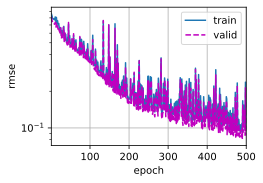

In [83]:
k, num_epochs, lr, weight_decay, batch_size =10, 500, 0.001, 0.1, 256

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [84]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。Detaching tensors is often useful when you don't want gradients to flow backward through a particular tensor
    # This is typically done to convert the tensor to a NumPy array using the numpy() function, as NumPy does not support automatic differentiation or require gradients.
    preds = net(test_features).detach().numpy()
    print(f"preds: {preds}")

In [ ]:
train_and_pred(train_features, test_features, train_labels, df_test,
               num_epochs, lr, weight_decay, batch_size)